# Data 200: Data Systems for Data Analytics


# Name:Kien Nguyen


### **Task**: Scrape data from Goodreads.com 📚

---

### **Objective**
you will scrape and analyze data from Goodreads.com. The work is split into two parts, each focusing on different aspects of the data
1. **"Best Books" Analysis**: Explore Goodreads' "Best Books" lists for a specific year.
2. **Author-Level Analysis**: Study the trends and patterns in the works of a specific author.

---

### **Instructions**

#### **Task 1: Best Books**
You are tasked with analyzing Goodreads' "Best Books" lists for a specific year:

[Best Books of 2021](https://www.goodreads.com/list/best_of_year/2021) 




**Tasks**:
1. Scrape data from the Goodreads "Best Books of [Year]" list:

2. Collect the following data for each book:
   - Title
   - Publication date (first published)
   - Author
   - Genre (if available, and feel free to pick the first genre listed)
   - Average rating
   - Number of ratings
   - Number of pages
   - Rank
   - Language (if available)
   - Number of people who are currently reading (if available)
   - Number of people who want to read (if available)
3. Perform the following analyses:
   - **Genre ratings**:
       - Compare average ratings across genres. Which 2-3 genres tends to have the highest ratings? Create a table showing average rating score, and average rank by genre.
   - **Popularity and ratings**:
       - Examine whether books with more ratings tend to have higher or lower average scores. Create a scatterplot showing the relationship between the number of ratings and average rating. On the x-axis, you should have **number of ratings**; on the y-axis, you should have **average rating**.

---

#### **Task 2: Author-Level Analysis**
analyzing books by a specific author:


Ernest Hemingway    | [Ernest Hemingway](https://www.goodreads.com/author/list/1455)     | Jul 21, 1899   |


**Tasks**:
1. Scrape all books by your assigned author:
   - Use the link provided for your author.
2. Collect the following data for each book:
   - Title
   - Publication date (first published)
   - Author
   - Genre (if available, and feel free to pick the first genre listed)
   - Average rating
   - Number of ratings
   - Number of pages
   - Rank (from the books written by the author)
   - Language (if available)
   - Number of people who are currently reading (if available)
   - Number of people who want to read (if available)
3. Performing the following analyses:
   - **Language Distribution**:
     - How many books has the author published in English? In other languages? Create a table showing the count of books by language.
   - **Author's Age and Page Count**:
     - Do authors tend to write longer books as they age? Use the author's birthday to calculate their age at the time of each book's publication. Create a line plot with **author's age** on the x-axis and **page count** on the y-axis.
   - **Author's Age and Rating**:
     - For English-only books, create a line plot with **author's age** on the x-axis and **average rating** on the y-axis.
     - Repeat the analysis including books in languages other than English. Does your interpretation change?
   - **Pages vs. Ratings**:
     - Is there a relationship between the number of pages and a book's average rating? Create a scatterplot with **page count** on the x-axis and **average rating** on the y-axis.
   - **Interest on a book**:
     - Is there a relationship between the number of people who are currently reading the book and the number of people who left a rating? Create a scatterplot with **number of people who are currently reading** on the x-axis and **number of ratings** on the y-axis. Create a second scatterplot with **average rating** on the y-axis. Do books with more interest tend to receive higher ratings?

---




### **Tips**
- Make sure to insert time.sleep() right after you request driver to go to a link (before requesting elements). Make sure to wait at least 0.7 second, or even slightly higher if you run into issues.
- Try-except blocks will be your friend because xpath positions on a page may differ depending on the book and content availability.

---

### **Resources**
- Selenium documentation: https://www.selenium.dev/documentation/
- Pandas documentation: https://pandas.pydata.org/docs/
- Matplotlib documentation: https://matplotlib.org/stable/contents.html



In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1: Top Books Analysis 

The goal of this task is to extract book data from **Goodreads' "Best Books" lists for 2021** and use it to analyze the **relationship between genres and ratings** as well as **the connection between popularity (ranking) and ratings**. Explanations and clarifications of the code will be provided through comments, while descriptive analysis and insights will be presented in separate Jupyter Notebook cells.

In [3]:
## Initialize an instance of the Selenium driver with ChromeDriverManager
chrome_options = Options()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

In [4]:
def scrape_book_url(url, ranks):
    """
    Scrapes book data from a given Goodreads book URL using Selenium and returns the extracted information.
    
    Parameters:
        url (str): The URL of the Goodreads book page to scrape.
        ranks (dict): A dictionary mapping URLs to their ranking.

    Returns:
        list: A list containing the book's rank, title, author, published date, genre, average rating, 
              number of ratings, number of pages, number of people currently reading, number of people wanting to read, and language.
    """
    try:
        # Navigate to the specified URL
        driver.get(url)
        time.sleep(1)

        # Close overlay popup if it exists
        overlay = driver.find_elements(By.CLASS_NAME, "Overlay__close")
        if len(overlay) > 0:
            try:
                close_overlay_button = overlay[0].find_element(By.TAG_NAME, "button")
                close_overlay_button.click()
                time.sleep(0.5)
            except Exception:
                pass

        # Extract the book's title
        title = safe_extract_text(lambda: driver.find_element(By.TAG_NAME, "h1").text)
        
        # Extract the author's name
        author = safe_extract_text(lambda: driver.find_element(By.XPATH, '//*[@data-testid="name"]').text)

        # Extract and parse the published date
        published_date_text = safe_extract_text(lambda: driver.find_element(By.XPATH, '//*[@data-testid="publicationInfo"]').text)
        published_date = safe_extract_text(lambda: re.search(r"(\w+\s\d{1,2},\s\d{4})", published_date_text).group(0))

        # Extract the main genre of the book
        main_genre = safe_extract_text(lambda: driver.find_element(By.CLASS_NAME, "BookPageMetadataSection__genreButton").text)

        # Extract the average rating of the book
        avg_rating = safe_extract_text(lambda: float(driver.find_element(By.CLASS_NAME, "RatingStatistics__rating").text))

        # Extract and parse the number of ratings
        num_ratings_text = safe_extract_text(lambda: driver.find_element(By.XPATH, '//*[@data-testid="ratingsCount"]').text)
        num_ratings = safe_extract_text(lambda: int(num_ratings_text.split(" ")[0].replace(",", "")))

        # Extract and parse the number of pages
        pages_text = safe_extract_text(lambda: driver.find_element(By.XPATH, '//*[@data-testid="pagesFormat"]').text)
        pages = safe_extract_text(lambda: int(pages_text.split(" ")[0]))

        # Extract the number of people currently reading the book
        people_readings_text = safe_extract_text(lambda: parse_large_num(driver.find_element(By.XPATH, '//*[@data-testid="currentlyReadingSignal"]').text.split(" ")[0]))

        # Extract the number of people wanting to read the book
        people_want_to_read_text = safe_extract_text(lambda: parse_large_num(driver.find_element(By.XPATH, '//*[@data-testid="toReadSignal"]').text.split(" ")[0]))

        # Open the "Book details and editions" section if available
        book_details_button = driver.find_elements(By.XPATH, '//*[@aria-label="Book details and editions"]')
        if book_details_button:
            driver.execute_script("arguments[0].click();", book_details_button[0])

        # Extract the language of the book from the details section
        last_desc_list = safe_extract_text(lambda: driver.find_elements(By.CLASS_NAME, "DescListItem")[-1])

        if last_desc_list is not None and "Language" in last_desc_list.text:
            language = safe_extract_text(lambda: last_desc_list.find_element(By.XPATH, './/*[@data-testid="contentContainer"]').text)
        else:
            language = None

        # Return the extracted data as a list
        return [ranks[url], title, author, published_date, main_genre, avg_rating, num_ratings, pages, people_readings_text, people_want_to_read_text, language]
        
    except Exception as e:
        print(f"Error scraping {url}: {e}")

def safe_extract_text(func, default=None):
    """
    Safely executes a function and extracts its returned value. If an exception occurs, 
    returns a default value instead.

    Parameters:
        func (callable): A function to be executed, typically used to retrieve text.
        default (any, optional): The default value to return if an exception occurs. Defaults to None.

    Returns:
        any: The result of the function execution, or the default value in case of an exception.
    """
    try:
        return func()
    except Exception:
        return default

def parse_large_num(text):
    """
    Parses a text representation of large numbers (e.g., "1.2k", "3.5m", or "1,200") into a 
    numerical value in thousands (k).

    Parameters:
        text (str): The string representation of the number to be parsed.

    Returns:
        float or None: The parsed number in thousands (k), or None if parsing fails.
    """
    try:
        if ("k" in text):
            return round(float(text.replace("k", "")), 2)
        if ("m" in text):
            return round(float(text.replace("m", ""))*1000, 2)
        if ("," in text):
            return round(float(text.replace(",", ""))/1000, 2)
        return round(float(text)/1000, 2)

    except Exception:
        return None

def print_progress_bar(current, total, bar_length=100):
    """
    Prints a progress bar in the console, replacing the current line.
    
    Parameters:
        current (int): The current progress (e.g., current iteration).
        total (int): The total value (e.g., total iterations).
        bar_length (int): The length of the progress bar in characters.
    """
    progress = current / total
    completed_length = int(bar_length * progress)
    bar = "=" * completed_length + "-" * (bar_length - completed_length)
    percentage = int(progress * 100)
    print(f"Progress: [{bar}] {percentage}% - {current} scraped out of {total}", end="\r")

### Getting all books URLs to scrape their details
The requirement is to scrape the details of all books in the 2021 Best Books; however, there are many book information and data points, such as the genres, number of pages, languages, etc. that cannot be retrieved only through the pages of the list. Therefore, we first need to scrape all of the books' URLs, and then go to each and every URLs to scrape their inner details.

In [5]:
starting_time = time.time()

urls_2021 = []
ranks_2021 = {}

def scrape_best_books_2021(total_pages):
    """
    Scrapes book URLs and their ranks from Goodreads' "Best Books of 2021" lists across multiple pages.
    
    Parameters:
        total_pages (int): The total number of pages to scrape (e.g., 14 pages for this dataset).
    """
    for i in range(1, total_pages+1):
        driver.get(f"https://www.goodreads.com/list/best_of_year/2021?id=157516.Best_Books_of_2021&page={i}")
        print(f"Scraping page {i} out of {total_pages} pages")
        time.sleep(0.7)

        # Close modal overlay pop-up if it exists
        overlay = driver.find_elements(By.CLASS_NAME, "modal--centered")
        if len(overlay) > 0:
            try:
                close_overlay_button = overlay[0].find_element(By.TAG_NAME, "button")
                close_overlay_button.click()
                time.sleep(3)
            except Exception:
                pass
        # Locate the main table containing the list of books
        mainBody = driver.find_element(By.ID, "all_votes")
        rows = mainBody.find_elements(By.TAG_NAME, "tr")

        # Loop through each row to extract book's rank and URL
        for row in rows:
            rank = int(row.find_element(By.CLASS_NAME, "number").text)
            url = row.find_element(By.CLASS_NAME, "bookTitle").get_attribute("href")
            
            urls_2021.append(url)
            ranks_2021[url] = rank

scrape_best_books_2021(14)
print(f"Number of books' URL to scrape: {len(urls_2021)}")

Scraping page 1 out of 14 pages
Scraping page 2 out of 14 pages
Scraping page 3 out of 14 pages
Scraping page 4 out of 14 pages
Scraping page 5 out of 14 pages
Scraping page 6 out of 14 pages
Scraping page 7 out of 14 pages
Scraping page 8 out of 14 pages
Scraping page 9 out of 14 pages
Scraping page 10 out of 14 pages
Scraping page 11 out of 14 pages
Scraping page 12 out of 14 pages
Scraping page 13 out of 14 pages
Scraping page 14 out of 14 pages
Number of books' URL to scrape: 1396


### Scrape for single book's detail
As it was depicted, the number of books to scrape is 1396, therefore the process of scraping for each book's details is gonna take a lot of computational time (roughly 2 hours based on the different machine). It should be noted also that due to the big amount of requests to the Goodreads server, some links may return a 502 Bad Gateway error. The code has been optimized so that the process will not break down in those situations, but the books whose URL requests are met with such errors will be filtered out later on in the data analysis part.

In [6]:
print("This is a long process, since we have to scrape all the individual book's URL.\nPlease wait patiently, or lower the number of pages scraped.")

books_2021 = []

for i, url in enumerate(urls_2021):
    book_data = scrape_book_url(url, ranks_2021)
    books_2021.append(book_data)
    print_progress_bar(i+1, len(urls_2021))

print("\nDone!")

This is a long process, since we have to scrape all the individual book's URL.
Please wait patiently, or lower the number of pages scraped.
Progress: [====================================================================================================] 100% - 1396 scraped out of 1396
Done!


### Inspect and prepare data for further data analysis

Through inspection, we can see that this dataset contains information about 1,396 books, with details related to their rank, title, author, genre, etc.. The dataset has 11 columns, with the following key details:

- **rank**: An integer value indicating the rank of the book (non-null for all entries).
- **title**: The title of the book (non-null for all entries).
- **author**: The author of the book (7 missing values).
- **published_date**: The publication date of the book (7 missing values).
- **main_genre**: The primary genre of the book (36 missing values).
- **avg_rating**: The average rating of the book on a scale (7 missing values, floating-point).
- **num_ratings**: The number of ratings the book has received (7 missing values, floating-point).
- **pages**: The number of pages in the book (29 missing values, floating-point).
- **people_readings_(thousand)**: The number of people who have read the book, measured in thousands (21 missing values).
- **people_want_to_read(thousands)**: The number of people who want to read the book, measured in thousands (11 missing values).
- **language**: The language of the book (21 missing values).

In [74]:
# Create a Pandas DataFrame for all the books' data
df_2021 = pd.DataFrame(books_2021, columns=['rank', 'title', 'author', 'published_date', 'main_genre', 'avg_rating', 'num_ratings', 
                                  'pages', 'people_readings_(thousands)', 'people_want_to_read_(thousands)', 'language'])

df_2021

,rank,title,author,published_date,main_genre,avg_rating,num_ratings,pages,people_readings_(thousands),people_want_to_read_(thousands),language
0,1,Project Hail Mary,Andy Weir,"May 4, 2021",Science Fiction,4.50,688658.0,476.0,44.20,662.00,English
1,2,The Four Winds,Kristin Hannah,"February 2, 2021",Historical Fiction,4.30,778170.0,464.0,48.20,516.00,English
2,3,Malibu Rising,Taylor Jenkins Reid,"May 27, 2021",Fiction,4.03,1137131.0,369.0,41.50,938.00,English
3,4,A Court of Silver Flames,Sarah J. Maas,"February 16, 2021",Fantasy,4.47,1537340.0,757.0,87.40,707.00,English
4,5,The Love Hypothesis,Ali Hazelwood,"September 14, 2021",Contemporary,4.13,1543673.0,373.0,39.90,1000.00,English
...,...,...,...,...,...,...,...,...,...,...,...
1391,1392,"Katharine Parr, the Sixth Wife",Alison Weir,"May 13, 2021",Historical Fiction,4.23,5342.0,544.0,0.43,13.00,English
1392,1392,Wicked Empire,Tracy Lorraine,"December 16, 2021",Dark,4.34,4580.0,336.0,1.22,2.27,English
1393,1394,Paradise Lagoon,Caroline Peckham,"October 18, 2021",Reverse Harem,4.44,10655.0,632.0,1.33,4.72,English
1394,1395,Carnival Hill,Caroline Peckham,"June 23, 2021",Reverse Harem,4.41,12267.0,449.0,1.18,5.05,English


In [75]:
## Inspect data information to detect invalid/NoneType data
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   rank                             1396 non-null   int64  
 1   title                            1396 non-null   object 
 2   author                           1389 non-null   object 
 3   published_date                   1389 non-null   object 
 4   main_genre                       1360 non-null   object 
 5   avg_rating                       1389 non-null   float64
 6   num_ratings                      1389 non-null   float64
 7   pages                            1367 non-null   float64
 8   people_readings_(thousands)      1375 non-null   float64
 9   people_want_to_read_(thousands)  1385 non-null   float64
 10  language                         1375 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 120.1+ KB


In [76]:
## Inspect numerical data points
df_2021.describe()

,rank,avg_rating,num_ratings,pages,people_readings_(thousands),people_want_to_read_(thousands)
count,1396.000000,1389.000000,1.389000e+03,1367.000000,1375.000000,1385.000000
mean,692.262178,4.006040,3.628990e+04,336.036576,2.523622,44.043451
std,401.772005,0.319559,1.160404e+05,124.704060,6.665520,98.811182
min,1.000000,2.000000,2.000000e+00,2.000000,0.000000,0.000000
25%,349.000000,3.800000,1.742000e+03,272.000000,0.160000,2.620000
50%,666.000000,4.030000,5.935000e+03,336.000000,0.560000,9.890000
75%,1039.000000,4.230000,2.297000e+04,391.000000,1.950000,36.000000
max,1396.000000,5.000000,1.543673e+06,1120.000000,98.500000,1000.000000


After inspection, we can deduce that the dataset contains some missing data that can affect the further calculation and analysis. The missing data can be due to the fact that the individual book's page on Goodreads does not contain the required information, or the process of scraping data meets with some network errors. 

To clean the data, we will drop all the null results from the four columns: **authors, main_genre, avg_rating, num_ratings**, since our analysis is based heavily on the genres as well as the ratings data, while the books without a respective author do indicate an invalid book as it makes little sense for a book without a writer.

After cleaning the data and drop the rows which contain the null results, our clean dataset now consists of 1360 books, as depicted below. The cleaned data is saved to `best_books_2021.csv`

In [78]:
# Drop invalid rows
cleaned_df_2021 = df_2021.dropna(subset=['author', 'main_genre', 'avg_rating', 'num_ratings'])

# Convert the column to datetime
cleaned_df_2021.loc[:, 'published_date'] = pd.to_datetime(cleaned_df_2021['published_date'], errors='coerce')

# Ensure the column has datetime values and then extract the date part
cleaned_df_2021.loc[:, 'published_date'] = cleaned_df_2021['published_date'].apply(lambda x: x.date() if pd.notna(x) else x)

cleaned_df_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1360 entries, 0 to 1395
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   rank                             1360 non-null   int64  
 1   title                            1360 non-null   object 
 2   author                           1360 non-null   object 
 3   published_date                   1360 non-null   object 
 4   main_genre                       1360 non-null   object 
 5   avg_rating                       1360 non-null   float64
 6   num_ratings                      1360 non-null   float64
 7   pages                            1339 non-null   float64
 8   people_readings_(thousands)      1359 non-null   float64
 9   people_want_to_read_(thousands)  1359 non-null   float64
 10  language                         1347 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 127.5+ KB


In [79]:
# Write cleaned data to csv file
cleaned_df_2021.to_csv('best_books_2021.csv', index=False, encoding='utf-8')

### Genre ratings analysis
Our target here is to compare average ratings and average popularity rank across genres. We are going to group the `genre` data with the `avg_rating` and the `rank` data, and create respective tables to determine their relationship. 

In [80]:
# Group genre with average ratings and popularity ranking, and create the respective tables with sorted data to demonstrate the relationship
genre_avg_rating_2021 = cleaned_df_2021.groupby('main_genre').agg(
    avg_rating=('avg_rating', 'mean'),
).reset_index()

genre_rank_2021 = cleaned_df_2021.groupby('main_genre').agg(
    rank=('rank', 'mean'),
).reset_index()

genre_avg_rating_2021 = genre_avg_rating_2021.sort_values(by='avg_rating', ascending=False)
genre_rank_2021 = genre_rank_2021.sort_values(by='rank', ascending=True)

In [81]:
genre_avg_rating_2021

,main_genre,avg_rating
4,Biblical Fiction,4.7000
40,Manga,4.6150
51,Parenting,4.6100
7,Christian,4.4825
60,Romantic Suspense,4.4800
...,...,...
36,LGBT,3.6360
11,Comics,3.6100
47,Novella,3.6000
19,Dystopia,3.5800


In [82]:
genre_rank_2021

,main_genre,rank
64,Spirituality,15.0
19,Dystopia,99.0
0,Adhd,163.0
4,Biblical Fiction,191.0
23,Fantasy Romance,193.0
...,...,...
20,Economics,1225.0
65,Sports Romance,1274.0
50,Paranormal Romance,1318.0
47,Novella,1337.0


The two tables provided give insight into the average ratings and popularity rankings of various book genres. The first table shows the average ratings (out of 5) for each genre, while the second table presents their popularity ranks, with a lower rank indicating greater popularity.

The first table highlights the average ratings for a range of genres. Among the genres listed, Biblical Fiction received the highest average rating of 4.7, indicating that it is the most positively regarded genre. Following closely are Manga and Parenting, with average ratings of 4.615 and 4.61, respectively. At the other end of the spectrum, Queer received the lowest rating of 3.54, followed by Dystopia (3.58) and Novella (3.6). These genres seem to have received more mixed or less favorable feedback from readers, as the topics described in the books may receive a diversity of opinion.

In terms of popularity, the second table ranks genres based on their popularity, where a lower rank represents higher popularity. Spirituality ranks 1st, making it the most popular genre, followed by Dystopia at 2nd, and Adhd at 3rd. On the other hand, genres such as Sports Romance (1274th), Paranormal Romance (1318th), and Novella (1337th) rank among the least popular, with significantly higher rank numbers.

A comparison between the two tables reveals several interesting trends. For instance, Biblical Fiction stands out not only as the highest-rated genre with an impressive rating of 4.7 but also maintains a relatively high popularity rank of 191st, suggesting that it is both highly regarded and also popular among Goodreads reader. In contrast, although Romantic Suspense achieves a top-5 rating, it performs poorly in terms of popularity, ranking at the bottom of the respective table. This could suggest that the dataset contains few books from this genre, and the high rating might be driven by a few standout books, rather than a widespread preference for the genre. Dystopia sees an opposite trend, with it ranking low on the ratings but are very popular among readers, which can be understood looking into the current world's situation.

It should be noted that, the genre in this dataset is the **main genre**, meaning that it is the first one listed on the book's web page, and a book can has many genres which can lead to a different interpretation. 









### Popularity and ratings analysis
Our target here is to compare popularity and ratings and determine their relationships. First, we need to inspect the data for the two columns `avg_rating` and `num_ratings`, to see if they contain outliers. If they do, we are going to drop all the instances of outliers, and work with the non-outlier dataset.

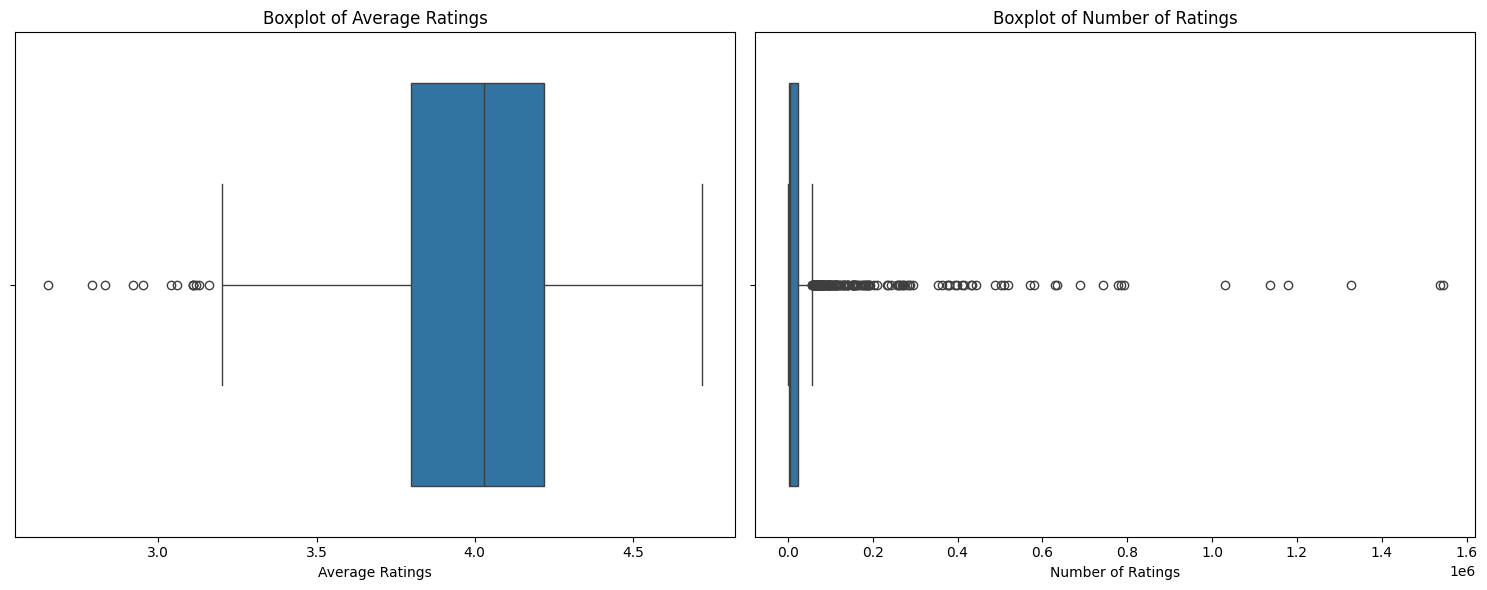

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# First boxplot
sns.boxplot(x=cleaned_df_2021['avg_rating'], ax=axes[0])
axes[0].set_title('Boxplot of Average Ratings')
axes[0].set_xlabel('Average Ratings')

# Second boxplot
sns.boxplot(x=cleaned_df_2021['num_ratings'], ax=axes[1])
axes[1].set_title('Boxplot of Number of Ratings')
axes[1].set_xlabel('Number of Ratings')

plt.tight_layout()
plt.show()

In [84]:
def drop_outliers(df, columns):
    """
    Drop outliers of given columns
    
    Parameters:
        df (pandas.DataFrame): DataFrame of the cleaned data
        columns (list): List of columns to be cleaned of outliers

    Returns:
        pandas.DataFrame: Cleaned DataFrame without outliers
    """
    for column in columns:
        # Compute Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1  # Interquartile Range
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

In [85]:
df_2021_drop_outliers = drop_outliers(cleaned_df_2021, ['avg_rating', 'num_ratings'])

In [86]:
print(f"Original data size: {cleaned_df_2021.shape[0]}")
print(f"Data size after outlier removal: {df_2021_drop_outliers.shape[0]}")

Original data size: 1360
Data size after outlier removal: 1170


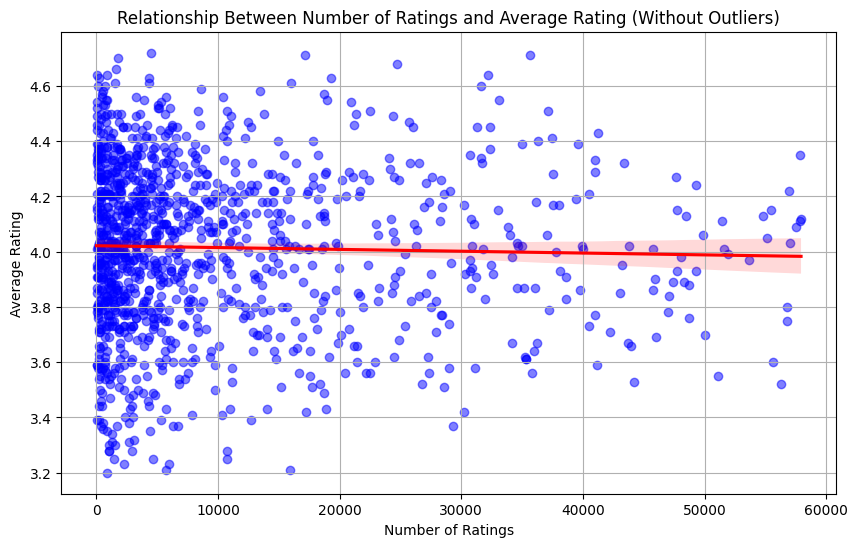

In [87]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='num_ratings', 
    y='avg_rating', 
    data=df_2021_drop_outliers, 
    scatter_kws={'alpha': 0.5, 'color': 'blue'}, 
    line_kws={'color': 'red'}
)

# Add labels and title
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.title('Relationship Between Number of Ratings and Average Rating (Without Outliers)')
plt.grid(True)

# Show plot
plt.show()

The scatterplot examines the relationship between the number of ratings a book receives and its average rating. The x-axis represents the number of ratings, while the y-axis indicates the average rating. 

A dense cluster of points is visible on the left side of the graph, where the number of ratings is relatively low (close to 0-10,000). Within this range, the average ratings vary widely, spanning from approximately 3.2 to 4.6, though the majority of books tend to hover around a 4.0 rating.

As the number of ratings increases, the points become more sparse, and a slight downward trend emerges. This trend is reinforced by the red regression line, which shows a subtle negative slope. The line suggests that books with a higher number of ratings tend to have slightly lower average ratings, although the relationship is weak. Notably, even books with tens of thousands of ratings still display considerable variation in their scores, ranging from around 3.4 to above 4.2.

While books with fewer ratings exhibit more variability in their average scores, books with a greater number of ratings tend to stabilize around a slightly lower rating, with a modest downward trend in averages as the number of ratings grows.

## Task 2: Author-Level Analysis

The goal of this task is to extract book data from Ernest Hemingway's catalogue on Goodreads and use it to analyze the following details:
- Distribution of languages for published books
- Relationship between author's age and average page written
- Relationship between author's age and average rating
- Relationship between average rating and number of pages
- The current interests in the book

Explanations and clarifications of the code will, as mentioned, be provided through comments, while descriptive analysis and insights will be presented in separate Jupyter Notebook cells.

### Getting all book's URL to scrape the data

Similarly to the previous task, this task we also aim to scrape all the books' URLs, and use the retrieved ones to scrape the inner details. However, after inspecting the data provided by Goodreads, it is evidently that a lot of the books in the catalogue are invalid and of little usages for analyzing the aforementioned details. Therefore, to reduce the number of URLs need to be scraped for this part, a set of conditions is introduced to determine whether or not a book listed in the catalogue should be considered a "valid" book. The conditions are:
1. **The book must be rated at least once.** This is because we are going to look into the number of ratings as well as average ratings, and the books that lack these details already will not be helpful in further analysis.
2. **The author name must be already presented in the row.** Although this is the catalogue of Ernest Hemingway, it is noticeable that many books either included Ernest Hemingway just as "introductor" or "reviewer", meaning he was not the actual author of the book, or the book is a compilation of many artists that cannot be assigned to Hemingway only. Therefore, only if the text "Ernest Hemingway" is presented, should it be considered a book by this respectable author.

In [20]:
urls_hemingway = []
ranks_hemingway = {}

def scrape_hemingway_books(total_pages):
    """
    Scrapes book URLs and their ranks from Goodreads' Ernest Hemingway catalogue across multiple pages.
    
    Parameters:
        total_pages (int): The total number of pages to scrape (e.g., 18 pages for this dataset).
    """
    for i in range(1, total_pages+1):
        driver.get(f"https://www.goodreads.com/author/list/1455.Ernest_Hemingway?page={i}&per_page=100")
        print(f"Scraping page {i} out of {total_pages} pages")
        time.sleep(0.7)

        # Close modal overlay pop-up if it exists
        overlay = driver.find_elements(By.CLASS_NAME, "modal--centered")
        if len(overlay) > 0:
            try:
                close_overlay_button = overlay[0].find_element(By.TAG_NAME, "button")
                close_overlay_button.click()
                time.sleep(3)
            except Exception:
                pass
                
        # Locate the main table containing the list of books
        mainBody = driver.find_element(By.CLASS_NAME, "tableList")
        rows = mainBody.find_elements(By.TAG_NAME, "tr")

        # Loop through each row to extract book's rank and URL
        for index, row in enumerate(rows):
            # Get book's ratings and author to remove invalid books
            ratings_text = row.find_element(By.CLASS_NAME, "minirating").text
            ratings = int(re.search(r"(?<=— )[\d,]+", ratings_text).group(0).replace(",", ""))
            author_name = row.find_element(By.CLASS_NAME, "authorName").text
            if "Ernest Hemingway" in author_name and ratings > 0:
                url = row.find_element(By.CLASS_NAME, "bookTitle").get_attribute("href")
                
                urls_hemingway.append(url)
                ranks_hemingway[url] = (i - 1) * 100 + index + 1

scrape_hemingway_books(18)
print(f"Number of books' URL to scrape: {len(urls_hemingway)}")

Scraping page 1 out of 18 pages
Scraping page 2 out of 18 pages
Scraping page 3 out of 18 pages
Scraping page 4 out of 18 pages
Scraping page 5 out of 18 pages
Scraping page 6 out of 18 pages
Scraping page 7 out of 18 pages
Scraping page 8 out of 18 pages
Scraping page 9 out of 18 pages
Scraping page 10 out of 18 pages
Scraping page 11 out of 18 pages
Scraping page 12 out of 18 pages
Scraping page 13 out of 18 pages
Scraping page 14 out of 18 pages
Scraping page 15 out of 18 pages
Scraping page 16 out of 18 pages
Scraping page 17 out of 18 pages
Scraping page 18 out of 18 pages
Number of books' URL to scrape: 674


### Scrape for single book's details

In [22]:
print("This is a long process, since we have to scrape all the individual book's URL.\nPlease wait patiently, or lower the number of pages scraped.")

books_hemingway = []

for i, url in enumerate(urls_hemingway):
    book_data = scrape_book_url(url, ranks_hemingway)
    books_hemingway.append(book_data)
    print_progress_bar(i+1, len(urls_hemingway))

print("\nDone!")

This is a long process, since we have to scrape all the individual book's URL.
Please wait patiently, or lower the number of pages scraped.
Progress: [====================================================================================================] 100% - 674 scraped out of 674
Done!


### Inspect and prepare data for further data analysis
Through inspection, we can see that this dataset contains information about 674 books, with details related to their rank, title, author, genre, etc.. The dataset has 11 columns, with the following key details:

- **rank**: An integer value indicating the rank of the book (non-null for all entries).
- **title**: The title of the book (non-null for all entries).
- **author**: The author of the book (6 missing values).
- **published_date**: The publication date of the book (242 missing values).
- **main_genre**: The primary genre of the book (493 missing values).
- **avg_rating**: The average rating of the book on a scale (non-null, floating-point).
- **num_ratings**: The number of ratings the book has received (non-null, floating-point).
- **pages**: The number of pages in the book (220 missing values, floating-point).
- **people_readings_(thousand)**: The number of people who have read the book, measured in thousands (365 missing values).
- **people_want_to_read(thousands)**: The number of people who want to read the book, measured in thousands (132 missing values).
- **language**: The language of the book (94 missing values).

In [23]:
df_hemingway = pd.DataFrame(books_hemingway, columns=['rank', 'title', 'author', 'published_date', 'main_genre', 'avg_rating', 'num_ratings', 
                                  'pages', 'people_readings_(thousands)', 'people_want_to_read_(thousands)', 'language'])
df_hemingway

,rank,title,author,published_date,main_genre,avg_rating,num_ratings,pages,people_readings_(thousands),people_want_to_read_(thousands),language
0,1,The Old Man and the Sea,Ernest Hemingway,"September 1, 1952",Literature,3.81,1211016.0,96.0,0.04,1.31,English
1,2,The Sun Also Rises,Ernest Hemingway,"October 22, 1926",Classics,3.79,462373.0,189.0,17.10,332.00,English
2,3,A Farewell to Arms,Ernest Hemingway,"September 1, 1929",Fiction,3.82,333111.0,293.0,10.70,265.00,English
3,4,For Whom the Bell Tolls,Ernest Hemingway,"October 1, 1940",Classics,3.98,302558.0,471.0,14.10,313.00,English
4,5,A Moveable Feast,Ernest Hemingway,"January 1, 1964",Nonfiction,4.02,157212.0,192.0,7.91,162.00,English
...,...,...,...,...,...,...,...,...,...,...,...
669,1101,Al otro lado del río y entre los árboles,Ernest Hemingway,None,None,3.00,1.0,NaN,NaN,NaN,Spanish; Castilian
670,1436,Poems: Ernest Hemingway,Ernest Hemingway,"November 24, 2024",None,5.00,3.0,73.0,0.00,NaN,English
671,1437,Two Tales of Darkness: 'A Man of the World' an...,Ernest Hemingway,"January 1, 1957",None,5.00,1.0,NaN,NaN,NaN,None
672,1438,The Sun Also Rises: A Norton Critical Edition ...,Ernest Hemingway,"June 10, 2022",None,3.00,1.0,362.0,0.00,0.00,English


In [24]:
df_hemingway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   rank                             674 non-null    int64  
 1   title                            674 non-null    object 
 2   author                           668 non-null    object 
 3   published_date                   532 non-null    object 
 4   main_genre                       175 non-null    object 
 5   avg_rating                       668 non-null    float64
 6   num_ratings                      668 non-null    float64
 7   pages                            448 non-null    float64
 8   people_readings_(thousands)      303 non-null    float64
 9   people_want_to_read_(thousands)  536 non-null    float64
 10  language                         572 non-null    object 
dtypes: float64(5), int64(1), object(5)
memory usage: 58.1+ KB


In [25]:
df_hemingway.describe()

,rank,avg_rating,num_ratings,pages,people_readings_(thousands),people_want_to_read_(thousands)
count,674.000000,668.000000,6.680000e+02,448.000000,303.000000,536.000000
mean,342.965875,3.666527,4.189287e+03,346.281250,0.243135,2.621287
std,212.664523,0.751192,5.341527e+04,417.628263,1.519364,23.999436
min,1.000000,1.000000,1.000000e+00,1.000000,0.000000,0.000000
25%,169.250000,3.250000,2.000000e+00,106.250000,0.000000,0.000000
50%,337.500000,3.770000,7.000000e+00,240.000000,0.000000,0.010000
75%,506.000000,4.052500,3.700000e+01,453.250000,0.010000,0.050000
max,1439.000000,5.000000,1.211016e+06,4489.000000,17.100000,332.000000


After inspection, we can deduce that the dataset contains some missing data that can affect the further calculation and analysis. The missing data can be due to the fact that the individual book's page on Goodreads does not contain the required information, or the process of scraping data meets with some network errors.

To clean the data, we will drop all the null results from the four columns: authors, avg_rating, num_ratings, since our analysis is based heavily on the ratings data, while the books without a respective author do indicate an invalid book as it makes little sense for a book without a writer.

After cleaning the data and drop the rows which contain the null results, our clean dataset now consists of 1360 books, as depicted below. The cleaned data is saved to hemingway_books.csv

In [90]:
# Drop invalid rows
cleaned_df_hemingway = df_hemingway.dropna(subset=['author', 'avg_rating', 'num_ratings'])

# Convert the column to datetime
cleaned_df_hemingway.loc[:, 'published_date'] = pd.to_datetime(cleaned_df_hemingway['published_date'], errors='coerce')

# Ensure the column has datetime values and then extract the date part
cleaned_df_hemingway.loc[:, 'published_date'] = cleaned_df_hemingway['published_date'].apply(lambda x: x.date() if pd.notna(x) else x)

cleaned_df_hemingway.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 0 to 673
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   rank                             668 non-null    int64  
 1   title                            668 non-null    object 
 2   author                           668 non-null    object 
 3   published_date                   530 non-null    object 
 4   main_genre                       175 non-null    object 
 5   avg_rating                       668 non-null    float64
 6   num_ratings                      668 non-null    float64
 7   pages                            448 non-null    float64
 8   people_readings_(thousands)      303 non-null    float64
 9   people_want_to_read_(thousands)  536 non-null    float64
 10  language                         572 non-null    object 
dtypes: float64(5), int64(1), object(5)
memory usage: 62.6+ KB


In [91]:
# Write cleaned data to csv file
cleaned_df_hemingway.to_csv('hemingway_books.csv', index=False, encoding='utf-8')

### Language analysis

In [195]:
# Create a Pandas DataFrame for all the books' data
df_hemingway_with_lang = cleaned_df_hemingway.dropna(subset=['language'])
print(f"Number of books with languages available: {df_hemingway_with_lang.shape[0]}")
print(f"Number of books in English: {df_hemingway_with_lang[df_hemingway_with_lang["language"] == "English"].shape[0]}")

Number of books with languages available: 572
Number of books in English: 292


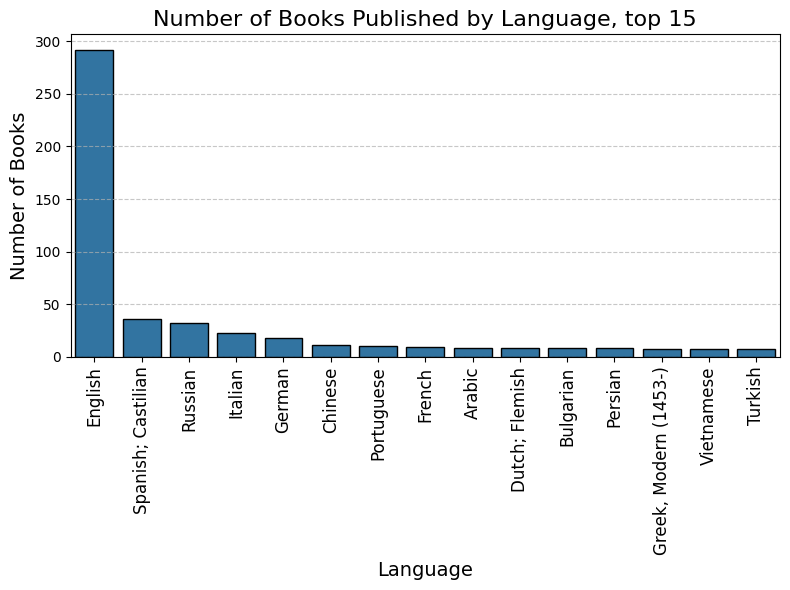

In [44]:
# Count books by language
books_by_language = df_hemingway_with_lang['language'].value_counts()

# Separate top 10 languages and group others
top_languages = books_by_language.head(15)

# Prepare the data for Seaborn
books_by_language_df = top_languages.reset_index()
books_by_language_df.columns = ['Language', 'Count']

# Plot a bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=books_by_language_df, x='Language', y='Count', edgecolor='black')
plt.title('Number of Books Published by Language, top 15', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Number of Books', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the table and the bar chart
plt.show()

The bar chart illustrates the number of books published in the top 15 languages. Overall, English dominates as the most significant language for book publications, while other languages lag far behind in comparison.

As depicted, English leads with a striking figure of nearly 300 books, which far exceeds the number published in any other language. This highlights its role as the most prominent language for literature or publications globally.

In contrast, Spanish (Castilian), the second-most prominent language, accounts for only around 40 books, representing a significant gap from English. Other languages, such as Russian and Italian, follow closely with slightly fewer than 40 books each. Meanwhile, German and Chinese have relatively moderate figures, hovering between 20 and 30 publications. Languages like Portuguese, French, Arabic, and Dutch each contribute a smaller number, approximately 10–15 books. Lastly, Vietnamese, Turkish, and Modern Greek round out the list with the lowest figures, each registering fewer than 10 books.



### Author's age analysis

In this part, the author's age relationship between **the average page counts**, as well as **the average ratings** will be examined. 

In [197]:
from dateutil.relativedelta import relativedelta

# Define Ernest Hemingway's birth and death dates in datetime format
birth_date = pd.to_datetime("1899-07-21").date()
death_date = pd.to_datetime("1961-07-02").date()

# Filter the dataframe to include only books published between birth and death dates
df_hemingway_with_date = cleaned_df_hemingway.dropna(subset=['published_date'])
df_hemingway_with_date = df_hemingway_with_date[(df_hemingway_with_date['published_date'] >= birth_date) & (df_hemingway_with_date['published_date'] <= death_date)]

def group_data_by_age(df, column, new_col_name):
    """
    Groups the data by the author's age at publication and calculates the mean of the specified column.

    Parameters:
    - df: The DataFrame containing the book data.
    - column: The column name (string) for which to calculate the mean (e.g., 'pages').
    - new_col_name: The name for the new column in the grouped DataFrame (e.g., 'average_page_count').

    Returns:
    - A new DataFrame grouped by age_at_publication, with the mean of the specified column.
    """
    df_drop_null = df.dropna(subset=[column])
    print(f"Number of books with appropriate dates: {df_drop_null.shape[0]}")
    df_drop_null = df_drop_null.copy()
    df_drop_null.loc[:, 'age_at_publication'] = df_drop_null['published_date'].apply(lambda x: relativedelta(x, birth_date).years)

    df_group = df_drop_null.groupby('age_at_publication').agg({column: 'mean'}).reset_index()
    df_group.columns = ['age_at_publication', new_col_name]

    return df_group

df_hemingway_with_date_and_page = group_data_by_age(df_hemingway_with_date, 'pages', 'average_page_count')
df_hemingway_with_date_and_page

Number of books with appropriate dates: 79


,age_at_publication,average_page_count
0,22,380.000000
1,23,19.000000
2,24,45.200000
3,25,47.500000
4,26,200.000000
5,27,60.727273
6,28,69.000000
7,29,322.500000
8,30,293.000000
9,32,274.000000


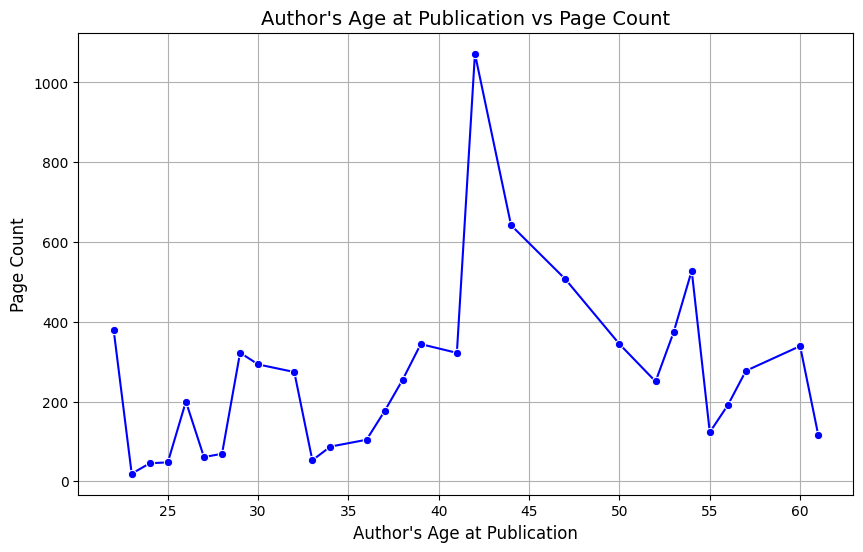

In [152]:
# Plotting age vs page count
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_hemingway_with_date_and_page, x='age_at_publication', y='average_page_count', marker='o', color='b')

# Adding labels and title
plt.title('Author\'s Age at Publication vs Page Count', fontsize=14)
plt.xlabel('Author\'s Age at Publication', fontsize=12)
plt.ylabel('Page Count', fontsize=12)

# Display plot
plt.grid(True)
plt.show()

The line chart illustrates the relationship between the Ernest Hemingway's age at publication and the page count of their books. Overall, the page count fluctuates significantly, but there is a particularly productive span between ages 40 and 54, where he produced their longest and most consistent works.

At the beginning of the timeline, between ages 22 and 35, the page count is highly irregular. At age 22, there was an initial peak of nearly 380 pages, followed by a sharp drop to near zero at age 23. The page count then oscillates between 50 and 200 pages, with a modest rise when he was 29 (around 320 pages) before falling again to low values at ages 32 and 33.

In his midlife years, Hemingway began a period of gradual growth in productivity, especially in between ages 40 and 54, when his page count reached its most significant and consistent levels. At his 40s, the page count was around 350 pages, and it climbed dramatically to over 1,000 pages at age 43, marking the highest point on the chart. Although the page count decreases after this peak, it remains substantial, with around 650 pages at age 44, but then witnessed a gradual decline in the following years. This period of decline also coincides with the gradual increase of Hemingway's mental problems in real life.

In [162]:
df_hemingway_with_date_english = df_hemingway_with_date[df_hemingway_with_date["language"] == "English"]
df_hemingway_with_date_non_english = df_hemingway_with_date[df_hemingway_with_date["language"] != "English"]

df_hemingway_with_date_and_ratings_english = group_data_by_age(df_hemingway_with_date_english, 'avg_rating', 'average_ratings')
df_hemingway_with_date_and_ratings_non_english = group_data_by_age(df_hemingway_with_date_non_english, 'avg_rating', 'average_ratings')

Number of books with appropriate dates: 64
Number of books with appropriate dates: 46


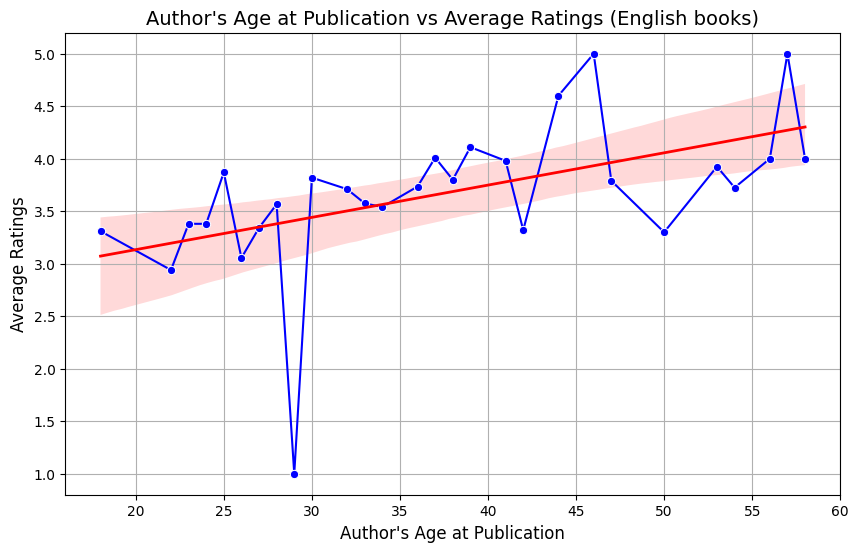

In [166]:
# Plotting age vs page count
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_hemingway_with_date_and_ratings_english, x='age_at_publication', y='average_ratings', marker='o', color='b')
sns.regplot(data=df_hemingway_with_date_and_ratings_english, x='age_at_publication', y='average_ratings', scatter=False, color='red', line_kws={'color': 'red', 'linewidth': 2})

# Adding labels and title
plt.title('Author\'s Age at Publication vs Average Ratings (English books)', fontsize=14)
plt.xlabel('Author\'s Age at Publication', fontsize=12)
plt.ylabel('Average Ratings', fontsize=12)

# Display plot
plt.grid(True)
plt.show()

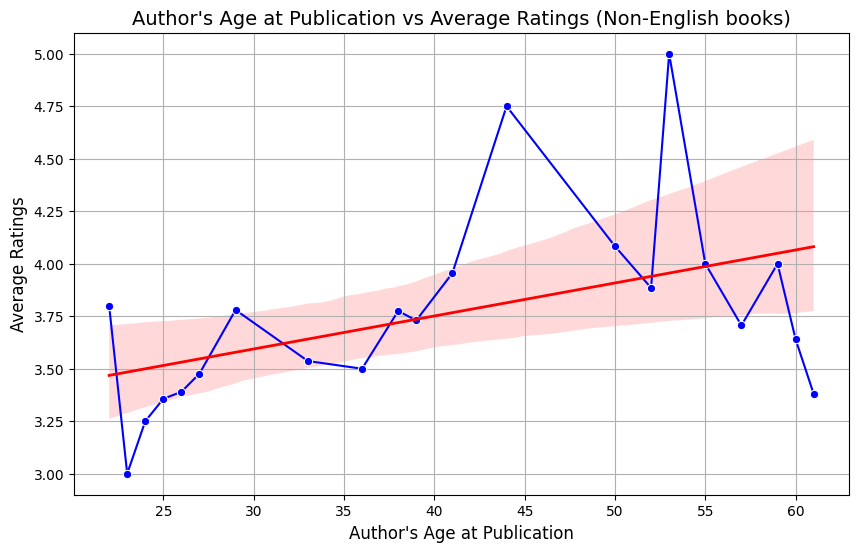

In [168]:
# Plotting age vs page count
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_hemingway_with_date_and_ratings_non_english, x='age_at_publication', y='average_ratings', marker='o', color='b')
sns.regplot(data=df_hemingway_with_date_and_ratings_non_english, x='age_at_publication', y='average_ratings', scatter=False, color='red', line_kws={'color': 'red', 'linewidth': 2})

# Adding labels and title
plt.title('Author\'s Age at Publication vs Average Ratings (Non-English books)', fontsize=14)
plt.xlabel('Author\'s Age at Publication', fontsize=12)
plt.ylabel('Average Ratings', fontsize=12)

# Display plot
plt.grid(True)
plt.show()

The two charts provided show the relationship between the Hemingway's age at the time of publication and the average ratings of his books, both in English and non-English languages. 

For English books, the data reveals an inverse relationship between the his age and the average ratings of the books published at that age. As he got older, the average ratings tend to increase, albeit with some fluctuations. The highest average rating is observed around the author's age of 40-45, as already analysed that it was his most productive era. 

The relationship between the Hemingway's age at publication and the average ratings of their non-English books is more complex. There is a general upward trend in the average ratings in correlation to him getting older, with some notable peaks and drops. The highest average rating is observed around the author's age of 45-50 similarly, while it is noticeable that the ratings for non-English books at the final stages of Hemingway's life both saw a sharp decline.

All in all, although there were some differences in the fluctuations between Hemingway's English and non-English cataglogue, it is it is clear that his works gained more admiration as he grew older, and there is a global consensus on the appreciation of his work.

### Relationship between pages and average ratings

The check for outliers for the number of pages and the average rating is performed similarly to the previous task

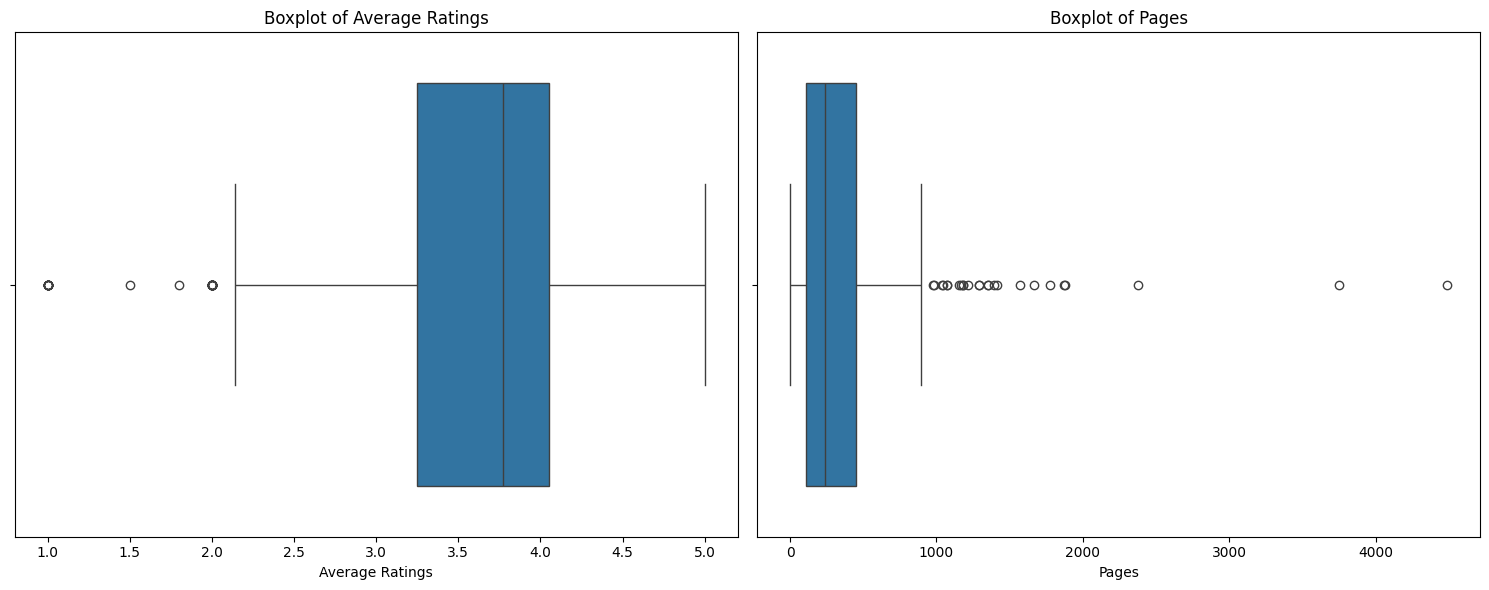

In [172]:
cleaned_df_hemingway.dropna(subset=['pages', 'avg_rating'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# First boxplot
sns.boxplot(x=cleaned_df_hemingway['avg_rating'], ax=axes[0])
axes[0].set_title('Boxplot of Average Ratings')
axes[0].set_xlabel('Average Ratings')

# Second boxplot
sns.boxplot(x=cleaned_df_hemingway['pages'], ax=axes[1])
axes[1].set_title('Boxplot of Pages')
axes[1].set_xlabel('Pages')

plt.tight_layout()
plt.show()

In [187]:
df_hemingway_drop_outliers_ratings_pages = drop_outliers(cleaned_df_hemingway, ['avg_rating', 'pages'])

print(f"Original data size: {cleaned_df_hemingway.shape[0]}")
print(f"Data size after outlier removal: {df_hemingway_drop_outliers_ratings_pages.shape[0]}")

Original data size: 668
Data size after outlier removal: 415


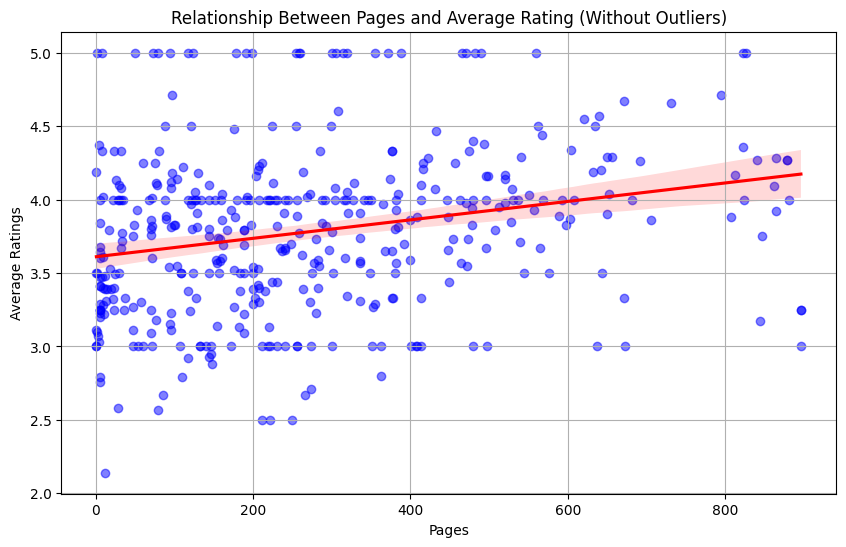

In [188]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='pages', 
    y='avg_rating', 
    data=df_hemingway_drop_outliers_ratings_pages, 
    scatter_kws={'alpha': 0.5, 'color': 'blue'}, 
    line_kws={'color': 'red'}
)

# Add labels and title
plt.xlabel('Pages')
plt.ylabel('Average Ratings')
plt.title('Relationship Between Pages and Average Rating (Without Outliers)')
plt.grid(True)

# Show plot
plt.show()

The chart shows the relationship between the number of pages in a book and the average rating of the book, and could potentially be used to analyze the writing patterns and audience reception of Ernest Hemingway. The chart displays a positive linear relationship between the number of pages and the average rating of Hemingway's books. As the number of pages increases, the average rating tends to rise, suggesting that Hemingway's longer works may have been better received by readers.

While the overall trend is positive, there is significant variation in the average ratings, even for books with similar page counts. This suggests that factors other than just the length of the book, such as the content, writing style, and critical reception, also played a role in determining the average ratings of Hemingway's works.

The chart shows a few data points that stand out as potential safe outliers, with either exceptionally high or low average ratings compared to the general trend. These could represent Hemingway's most well-received or lesser-known works, and would be worth further investigation in the future.

### Current interests in the books

This part inspects the interests in Hemingway's catalogue by looking into the relationship between the number of current people reading his works and both the number of ratings and the average ratings. In this part, it should be noted that outliers **will be taken into account**, due to the fact that there are too few people who are currently reading his works, so the introduction of outliers for the books that have more people interested will be worth investigating.

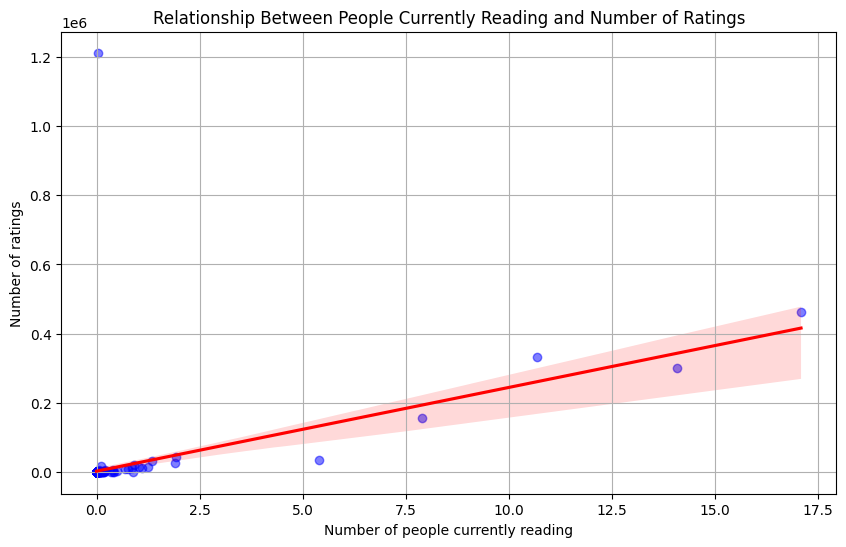

In [199]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='people_readings_(thousands)', 
    y='num_ratings', 
    data=cleaned_df_hemingway, 
    scatter_kws={'alpha': 0.5, 'color': 'blue'}, 
    line_kws={'color': 'red'}
)

plt.xlabel('Number of people currently reading')
plt.ylabel('Number of ratings')
plt.title('Relationship Between People Currently Reading and Number of Ratings')
plt.grid(True)

plt.show()

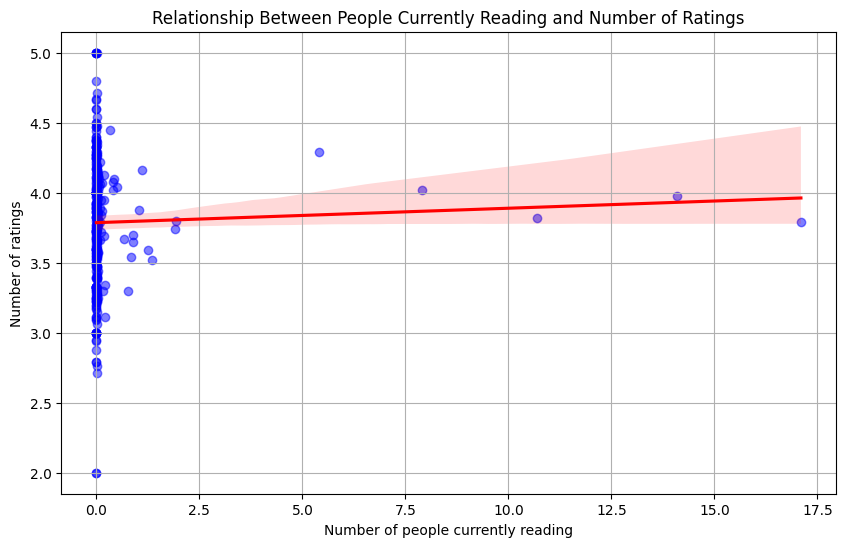

In [194]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='people_readings_(thousands)', 
    y='avg_rating', 
    data=cleaned_df_hemingway, 
    scatter_kws={'alpha': 0.5, 'color': 'blue'}, 
    line_kws={'color': 'red'}
)

# Add labels and title
plt.xlabel('Number of people currently reading')
plt.ylabel('Number of ratings')
plt.title('Relationship Between People Currently Reading and Number of Ratings')
plt.grid(True)

# Show plot
plt.show()

Both charts show a positive linear relationship between the number of people currently reading and the number of ratings, as well as the average ratings. As the number of people currently reading increases, the number of ratings and the average ratings tend to rise as well. The charts contain a few outliers, which are data points that deviate significantly from the general trend. In the first chart, the outlier at around 15 people currently reading shows a higher number of ratings compared to the trend. In the second chart, the outlier at around 15 people currently reading also exhibits a higher average rating compared to the trend.

The outliers in the data could represent Hemingway's most popular or critically acclaimed works, which have attracted a relatively small but highly engaged readership. These outliers may also indicate that certain Hemingway books have resonated strongly with a dedicated group of readers, leading to a disproportionately high number of ratings and average ratings compared to the general trend.